# Watershed and stream network delineation with Python and Pysheds - Tutorial

For this exercise we will follow a typical workflow of delineating an upstream catchment and stream network from a point location such as a water quality monitoring site. To acheive this, there are several steps to complete:

- Read in raster data,
- Create a flow direction raster
- Delineate the catchment,
- Plot the DEM, catchment, and generate the stream network.

This work can be completed in ArcGIS (or using ArcPy) but as this is an open-source course, we will be using the widely applicable Pysheds package. As with most python scripts, the first step is to import the packages we will need in this work.

If when you run the import statements below you receive an error, such as "package not found". You will need to open the Anaconda Prompt from the start menu and type pip install [package name]. For example, if you get a message that mplleaflet can not be found, you would open Anaconda prompt, type pip install mplleaflet and then hit ENTER.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import geopandas as gpd
import os
from pysheds.grid import Grid
import mplleaflet
import warnings
import rasterio
warnings.filterwarnings('ignore')
%matplotlib inline

It is also very helpful to specify a working folder. Examples of this could include 'C:temp' or for the purposes of this workshop 'C:\ACWA_workshop_files'. To create a working directory we can specify the file path and if the folder does not exist have Windows create it.

In [2]:
# Create a working directory
working_directory = 'C:\ACWA_workshop_files\Ex2_h20delineation'
if not os.path.exists(working_directory): os.makedirs(working_directory)

### Download National Elevation Data
The National Elevation Dataset (NED) can be downloaded at many different resolutions, including 1/9 arc-seconds (3 meters), 1/3 arc-seconds (10 meters) and 30 meter gridded products. National Elevation Data can be downlowded from several locations. One easy place to get this data from is the NRCS Geospatial Data Gateway: 

https://gdg.sc.egov.usda.gov/GDGOrder.aspx

Using code we developed from the previous exercise, you can download elevation data using the wget package. However, because the download time can take quite a while, we've provided a pre-clipped geotiff included in the Day 2 data folder, titled 'sampleDEM.tif'. 

To load the Digital Elevation Model (DEM) we will need to modify to file path pointing to the downloaded data folder. You can then use the pysheds.grid tools to read in the raster. Here, we will create a simple function to plot gridded data using a set of parameters so that we don't have to type each of the lines again in later sections.

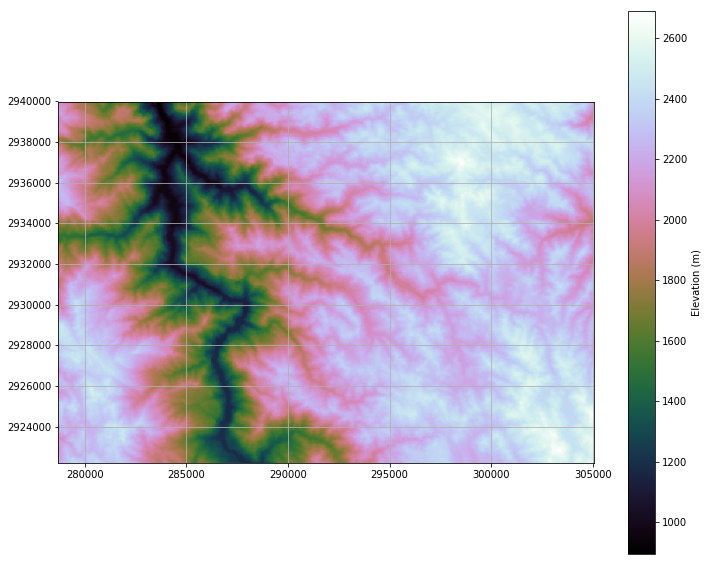

In [250]:
data_folder = 'E:/R course/Day 2/data'

grid = Grid.from_raster(os.path.join(data_folder, 'sampleDEM.tif'), data_name='dem')

def plotFigure(data, label, cmap='cubehelix'):
    plt.figure(figsize=(12,10))
    plt.imshow(data, extent=grid.extent, cmap=cmap)
    plt.colorbar(label=label)
    plt.grid()

plotFigure(grid.dem, 'Elevation (m)')

### Determine the flow direction
The grid.flowdir tool creates a raster of flow direction from each cell to its steepest downslope neighbor.

This tool takes a surface as input and outputs a raster showing the direction of flow out of each cell. There are eight valid output directions relating to the eight adjacent cells into which flow could travel. This approach is commonly referred to as an eight-direction (D8) flow model and follows an approach presented in Jenson and Domingue (1988).

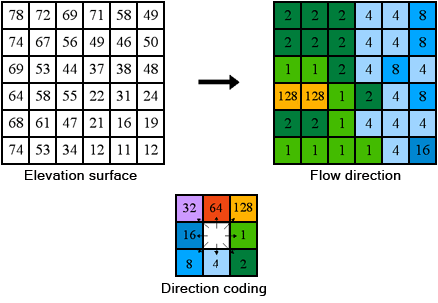

The D-Infinity (DINF) flow method, described by Tarboton (1997), determines flow direction as the steepest downward slope on eight triangular facets formed in a 3x3 cell window centered on the cell of interest. Computationally this is much more expensive.

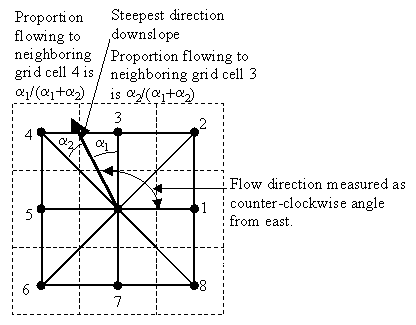

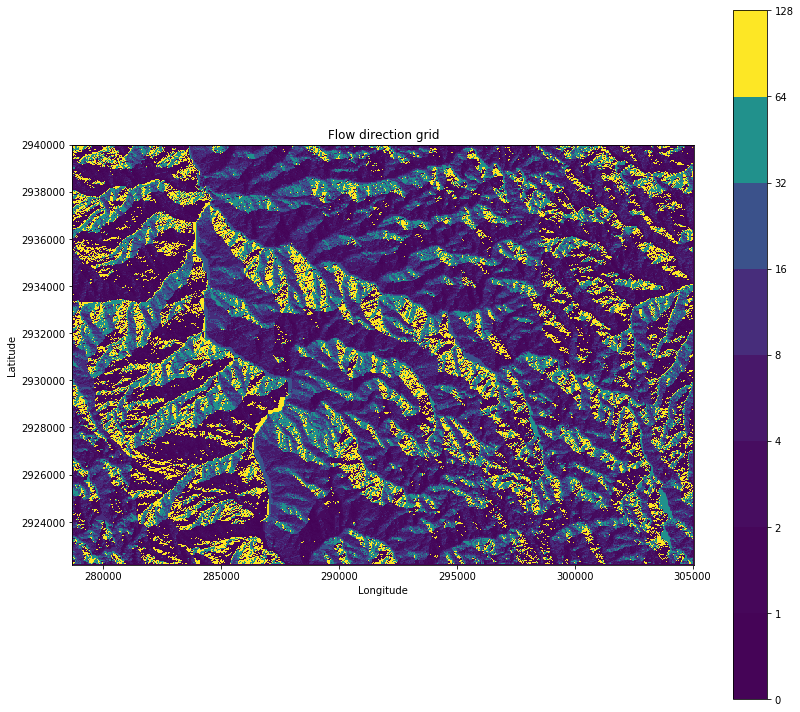

In [251]:
#N    NE    E    SE    S    SW    W    NW
dirmap = (64,  128,  1,   2,    4,   8,    16,  32)

grid.flowdir(data='dem', out_name='dir', dirmap=dirmap)

plt.figure(figsize=(12,10))
plt.imshow(grid.dir, extent=grid.extent, cmap='viridis', zorder=2)
boundaries = ([0] + sorted(list(dirmap)))
plt.colorbar(boundaries= boundaries,
             values=sorted(dirmap))
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Flow direction grid')
plt.grid(zorder=-1)
plt.tight_layout()

It may be usefule to see later, so let's also save a geoTiff of the flow direction raster.

In [256]:
flowView = grid.view('dir', nodata=np.nan)
grid.to_raster(flowView, os.path.join(working_directory, 'Day2_example_flowdir.tif'))

### Define catchment based on DEM

To delineate the catchment from a specific locations, such as a water quality monitoring site, we will need the specific location. Typically this is provided as latitude and longitude coordinates, but we need to be carefull that the lat/longs are in the same geographic projection of the DEM. In this case we will use the converted coordinates in Universal Transverse Mercator (UTM).

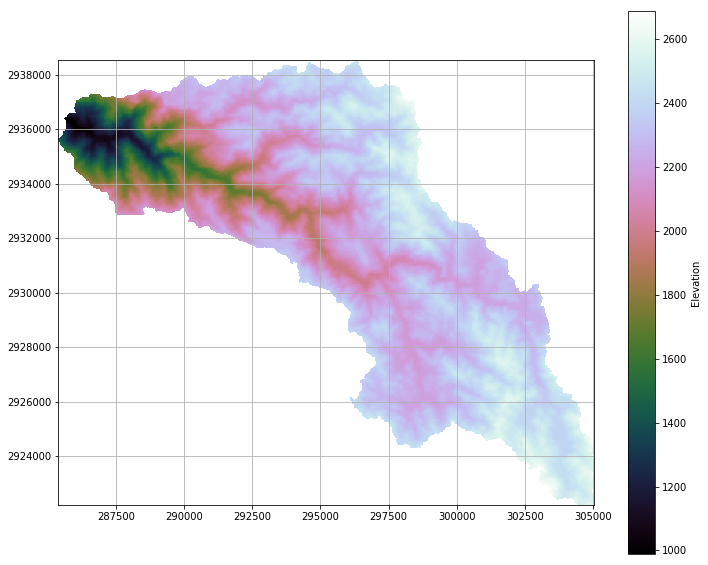

In [253]:
# Specify pour point
x, y = 285612.017,2936416.682

# Delineate the catchment
grid.catchment(data='dir', x=x, y=y, dirmap=dirmap, out_name='catch',
               recursionlimit=15000, xytype='label', nodata_out=0)

# Clip the bounding box to the catchment
grid.clip_to('catch')

# Get a view of the catchment
demView = grid.view('dem', nodata=np.nan)
plotFigure(demView,'Elevation')

#export selected raster
grid.to_raster(demView, os.path.join(working_directory, 'Day2_example_catchment.tif'))

### Define the flow accumulation grid

The flow accumulation tool creates a raster of accumulated flow to each cell, as determined by accumulating the weight for all cells that flow into each downslope cell. The accumulated flow is based on the number of cells flowing into each cell in the output raster. The current processing cell is not considered in this accumulation. Output cells with a high flow accumulation are areas of concentrated flow and can be used to identify stream channels. Output cells with a flow accumulation of zero are local topographic highs and can be used to identify ridges.

We can use the flow accumulation grid to then extract the river network.

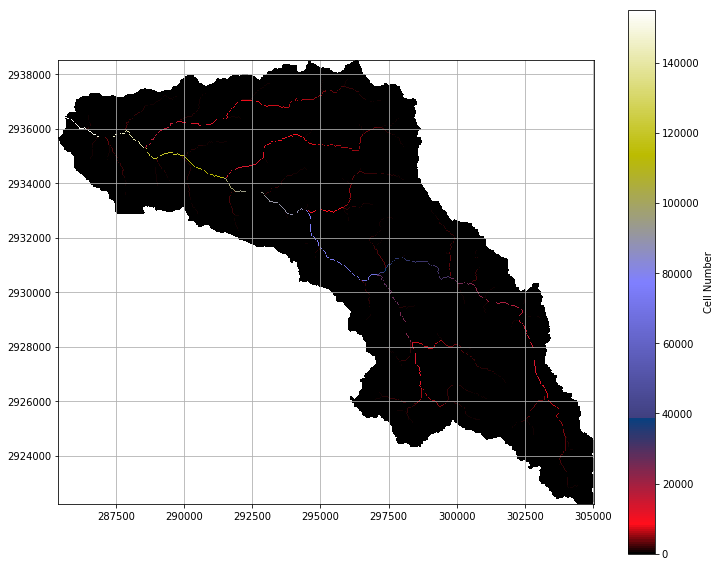

In [257]:
grid.accumulation(data='catch', dirmap=dirmap, pad_inplace=False, out_name='acc')
accView = grid.view('acc', nodata=np.nan)
plotFigure(accView,"Cell Number",'gist_stern')

grid.to_raster(accView, os.path.join(working_directory, 'Day2_example_flow accumulation.tif'))

streams = grid.extract_river_network('catch', 'acc', threshold=100, dirmap=dirmap)
streams["features"][:2]

def saveDict(dic,file):
    f = open(file,'w')
    f.write(str(dic))
    f.close()

#save geojson as separate file
saveDict(streams, os.path.join(working_directory, 'Day2_example_streams.geojson'))

### Plot the DEM and stream network
Once you've delineated the stream network, it can be helpful to plot it as a polygon. You can play with the threshold parameter to determine how much of the small ephemeral/intermittent streams are included.

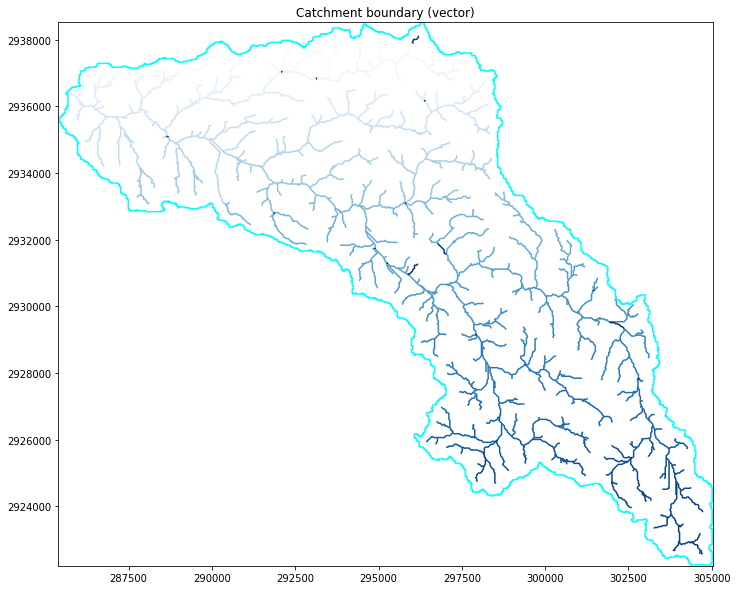

In [255]:
streamNet = gpd.read_file(os.path.join(working_directory, 'Day2_example_streams.geojson'))
#streamNet.crs = {'init' :'epsg:32613'}

# The polygonize argument defaults to the grid mask when no arguments are supplied
shapes = grid.polygonize()

# Plot catchment boundaries
fig, ax = plt.subplots(figsize=(12, 10))

for shape in shapes:
    coords = np.asarray(shape[0]['coordinates'][0])
    ax.plot(coords[:,0], coords[:,1], color='cyan')

ax.set_xlim(grid.bbox[0], grid.bbox[2])
ax.set_ylim(grid.bbox[1], grid.bbox[3])
ax.set_title('Catchment boundary (vector)')
gpd.plotting.plot_dataframe(streamNet, None, cmap='Blues', ax=ax)

### BONUS: Quickly load the stream network into Google Earth for heads up validation

In [241]:
streamNet.crs = {'init' :'epsg:32613'}
ax = streamNet.plot()
mplleaflet.display(fig=ax.figure, crs=streamNet.crs, tiles='esri_aerial')

### Exercise 3: Delineate a watershed in WI
Using the code provided above your goal is to now delineate a watershed using the following information:

- Create a new working directory titled Exercise 3
- Use the same DEM from you 'Day 2/data' folder.
- Use x and y coordinates: 296868.001, 2930650.001
- Generate a catchment boundary plot using a flow accumulation threshold of 150

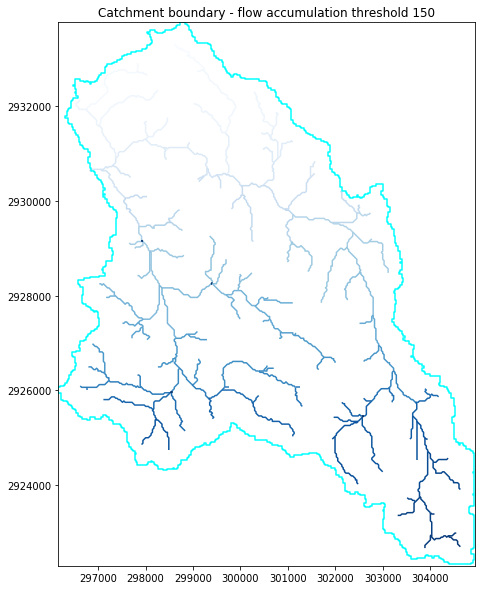

In [265]:
# Create a working directory
working_directory = 'C:\ACWA_workshop_files\Ex2_h20delineation\exercise3'
if not os.path.exists(working_directory): os.makedirs(working_directory)

# Specify pour point
x, y = 296868.001, 2930650.001

# Delineate the catchment
grid.catchment(data='dir', x=x, y=y, dirmap=dirmap, out_name='catch',
               recursionlimit=15000, xytype='label', nodata_out=0)

# Clip the bounding box to the catchment
grid.clip_to('catch')

# Create flow accumulation
grid.accumulation(data='catch', out_name='acc')
streams = grid.extract_river_network('catch', 'acc', threshold=150, dirmap=dirmap, inplace=False)
streams["features"][:2]

# Save geojson for flow accumulation
saveDict(streams, os.path.join(working_directory, 'streams_exercise3_flowacc200.geojson'))

# Plot stream network for flow accumulation
streamNet = gpd.read_file(os.path.join(working_directory, 'streams_exercise3_flowacc200.geojson'))
shapes = grid.polygonize()
fig, ax = plt.subplots(figsize=(12, 10))

for shape in shapes:
    coords = np.asarray(shape[0]['coordinates'][0])
    ax.plot(coords[:,0], coords[:,1], color='cyan')

ax.set_xlim(grid.bbox[0], grid.bbox[2])
ax.set_ylim(grid.bbox[1], grid.bbox[3])
ax.set_title('Catchment boundary - flow accumulation threshold 150')
gpd.plotting.plot_dataframe(streamNet, None, cmap='Blues', ax=ax)